### This notebook uses a breathing actuation sequence that computes triggers inflation deflation based upon an average inhale/exhale duration and a scale factor

In [1]:
from pythonosc import dispatcher, osc_server
from pythonosc.udp_client import SimpleUDPClient
import biofeatures
import threading
import numpy as np

In [2]:
def data_handler(unused_addr, args, data1, data2, data3, data4, data5, data6): #BITalino ServerBIT format
# def data_handler(unused_addr, args, values): #R-IoT Node-RED format

    global ecg_data, resp_data
    global osc_client
    
    B = args[0]
    HR = args[1]
    
    # print(data5) # breathing
    # print(data6) # ECG
    
    # BITalino ServerBIT
    ecg_data.append(float(np.random.rand(1)))
    resp_data.append(float(data5))

    # R-IoT Node-RED
#     resp_data.append(np.float(values.split("\t")[5]))
#     ecg_data.append(np.random.rand(1)[0])

        
    if B.is_warmed_up:
        B.set_data(resp_data[-B.buffer_length:])
    
    if HR.is_warmed_up:
        HR.set_data(ecg_data[-HR.buffer_length:])
    


In [3]:
def warmup(B, resp_data, HR, ecg_data):
    """Function to launch once the system has warmed up.
    Sets the  data initially and launches a recursive update of features.
    Parameters
    ----------
    B: object containing breathing data and features
    resp_data: respiration signal data to set
    HR: object containing ECG data and features
    ecg_data: ecg signal data to set
    """
    
    if not B.is_warmed_up:
        print("Breathing WARMUP")
        B.set_data(resp_data[-B.buffer_length:])
        B.is_warmed_up = True
        B.update_loop()
        
    if not HR.is_warmed_up:
        print("ECG WARMUP")
        HR.set_data(ecg_data[-HR.buffer_length:])
        HR.is_warmed_up = True
        HR.update_loop()
        
    breathing_factor = 1.2
    
    timer_actuation = threading.Timer(0.1, breathing_actuation, [B, breathing_factor, True] )
    timer_actuation.start()

### Different actuation sequences

In [4]:
# computes inhale and exhale interval duration as average duration of breath * breathing_factor 

def breathing_actuation(B, breathing_factor, inflate):
    global osc_client, actuation_flag
    
    if not actuation_flag:
        return
    
    if inflate:
        print("inhale: ", B.features['avg_inhale'])
        osc_client.send_message("/actuator/inflate", 100.0)
        timer_exhale = threading.Timer(B.features['avg_inhale'] * breathing_factor, breathing_actuation, [B, breathing_factor, False])
        timer_exhale.start()
        
        for i in range(1,10):
            osc_client.send_message("/actuator/inflate", 100.0)

    else:
        print("exhale: ", B.features['avg_inhale'])
        osc_client.send_message("/actuator/inflate", -100.0)
        timer_inhale = threading.Timer(B.features['avg_inhale'] * breathing_factor, breathing_actuation, [B, breathing_factor, True])
        timer_inhale.start()
        
        for i in range(1,10):
            osc_client.send_message("/actuator/inflate", -100.0)


In [ ]:
# specify inhale and exhale interval duration in seconds

def breathing_intervals(inhale_duration, exhale_duration, inflate):
    global osc_client, actuation_flag
    
    if not actuation_flag:
        return
    
    if inflate:
        print("inhale: ", inhale_duration)
        osc_client.send_message("/actuator/inflate", 100.0)
        timer_exhale = threading.Timer(inhale_duration, breathing_intervals, [inhale_duration, exhale_duration, False])
        timer_exhale.start()

    else:
        print("exhale: ", exhale_duration)
        osc_client.send_message("/actuator/inflate", -100.0)
        timer_inhale = threading.Timer(exhale_duration, breathing_intervals, [inhale_duration, exhale_duration, True])
        timer_inhale.start()

In [ ]:
# specify duration of one breath in seconds and inhale/exhale ratio in percentage

def breathing_ratio(breath_duration, in_ex_ratio, inflate):
    global osc_client, actuation_flag
    
    if not actuation_flag:
        return
    
    if inflate:
        interval_length = breath_duration * in_ex_ratio
        print("inhale: ", interval_length)
        osc_client.send_message("/actuator/inflate", 100.0)
        timer_exhale = threading.Timer(interval_length, breathing_ratio, [breath_duration, in_ex_ratio, False])
        timer_exhale.start()

    else:
        interval_length = breath_duration * (1 - in_ex_ratio)
        print("exhale: ", interval_length)
        osc_client.send_message("/actuator/inflate", -100.0)
        timer_inhale = threading.Timer(interval_length, breathing_ratio, [breath_duration, in_ex_ratio, True])
        timer_inhale.start()

In [ ]:
# computes degree of inflation/deflation based on ECG features

# TODO: how to compute the inflation/deflation value?

def heartrate_actuation(HR, timer_interval):
    global osc_client, actuation_flag
    
    if not actuation_flag:
        return
    
    current_trend = HR.current_trends["hr_mean"]
    #current_trend = HR.current_trends["rmssd"]
    #current_trend = HR.current_trends["LF/HF ratio"]
    
    current_feature = HR.features[-1]["hr_mean"]
    #current_feature = HR.features[-1]["rmssd"]
    #current_feature = HR.features[-1]["LF/HF ratio"]
    
    if current_trend > 0:
        print("inhale: ", B.features['avg_inhale'])
        osc_client.send_message("/actuator/inflate", 100.0)
        #osc_client.send_message("/actuator/inflate", current_trend * 1000/current_feature)
        timer_exhale = threading.Timer(timer_interval, heartrate_actuation, [HR, timer_interval])
        timer_exhale.start()

    else:
        print("exhale: ", B.features['avg_exhale'])
        #osc_client.send_message("/actuator/inflate", current_trend * 1000/current_feature)
        osc_client.send_message("/actuator/inflate", -100.0)
        timer_inhale = threading.Timer(timer_interval, heartrate_actuation, [HR, timer_interval])
        timer_inhale.start()

#### Set up configuration: IP (BITalino, R-IoT or Node-RED), port and OSC address pattern

In [5]:
# Definitions
bitalino_ip = "127.0.0.1"
bitalino_port = 8000

riot_ip = "192.168.0.102"
riot_port = 31000 

# riot_ip = "192.168.1.40"
# riot_port = 12000 

actuator_ip = '192.168.0.110'
actuator_port = 12000

riot_address = "/raw/"
bitalino_address = "/0/bitalino"


# Configuration 
config_address = bitalino_address
config_ip = bitalino_ip
config_port = bitalino_port

osc_client = SimpleUDPClient(actuator_ip, actuator_port) 

actuation_flag = True

ecg_data = []
resp_data = []

B = biofeatures.breathing(data = np.ones(10), buffer_length=2000, srate=100)
HRV = biofeatures.hrv(data = np.ones(10), buffer_length=2000, srate=100)

my_dispatcher = dispatcher.Dispatcher()
my_dispatcher.map(config_address, data_handler, B, HRV)

server = osc_server.ThreadingOSCUDPServer((config_ip, config_port), my_dispatcher)
print("Serving on {}".format(server.server_address))

# Warmup
warmup_t = 10
timer_warmup = threading.Timer(warmup_t, warmup, [B,resp_data,HRV,ecg_data])
timer_warmup.start()

try: 
    server.serve_forever()
except KeyboardInterrupt:
    B.update_data_flag = False
    HRV.update_data_flag = False
    actuation_flag = False
    server.server_close()
    osc_client.send_message("/actuator/inflate", 0.0)
except:
    raise

Serving on ('127.0.0.1', 8000)
Breathing WARMUP
{'breath_avg_len': 3.32, 'inhale_duration': 5.45, 'avg_inhale': 2.72, 'exhale_duration': 4.5, 'avg_exhale': 2.25, 'inhale_exhale_ratio': 1.21}
ECG WARMUP
[{'nni_mean': -13.29, 'hr_mean': 167.77, 'hr_std': 80.93, 'rmssd': 2177.61, 'lf': 83280.79, 'hf': 11954.2, 'LF/HF ratio': 6.97}]
inhale:  2.72
{'breath_avg_len': 3.49, 'inhale_duration': 5.86, 'avg_inhale': 2.93, 'exhale_duration': 4.62, 'avg_exhale': 2.31, 'inhale_exhale_ratio': 1.27}
[{'nni_mean': -13.29, 'hr_mean': 167.77, 'hr_std': 80.93, 'rmssd': 2177.61, 'lf': 83280.79, 'hf': 11954.2, 'LF/HF ratio': 6.97}, {'nni_mean': -23.16, 'hr_mean': 169.96, 'hr_std': 79.94, 'rmssd': 2239.32, 'lf': 89911.52, 'hf': 13071.03, 'LF/HF ratio': 6.88}]
{'breath_avg_len': 3.64, 'inhale_duration': 6.19, 'avg_inhale': 3.1, 'exhale_duration': 4.72, 'avg_exhale': 2.36, 'inhale_exhale_ratio': 1.31}
[{'nni_mean': -13.29, 'hr_mean': 167.77, 'hr_std': 80.93, 'rmssd': 2177.61, 'lf': 83280.79, 'hf': 11954.2, 'LF

{'breath_avg_len': 3.2, 'inhale_duration': 8.81, 'avg_inhale': 2.2, 'exhale_duration': 7.2, 'avg_exhale': 1.8, 'inhale_exhale_ratio': 1.22}
[{'nni_mean': -14.68, 'hr_mean': 171.2, 'hr_std': 75.51, 'rmssd': 2510.06, 'lf': 78358.42, 'hf': 19160.16, 'LF/HF ratio': 4.09}, {'nni_mean': 412.5, 'hr_mean': 175.34, 'hr_std': 71.94, 'rmssd': 279.46, 'lf': 10833.54, 'hf': 19737.09, 'LF/HF ratio': 0.55}, {'nni_mean': -23.58, 'hr_mean': 171.98, 'hr_std': 74.99, 'rmssd': 2621.36, 'lf': 76175.08, 'hf': 20690.42, 'LF/HF ratio': 3.68}, {'nni_mean': 426.36, 'hr_mean': 172.11, 'hr_std': 73.19, 'rmssd': 296.75, 'lf': 10709.25, 'hf': 17965.47, 'LF/HF ratio': 0.6}, {'nni_mean': 434.55, 'hr_mean': 170.82, 'hr_std': 73.12, 'rmssd': 327.45, 'lf': 12280.82, 'hf': 16697.77, 'LF/HF ratio': 0.74}]
{'breath_avg_len': 3.31, 'inhale_duration': 9.65, 'avg_inhale': 2.41, 'exhale_duration': 6.88, 'avg_exhale': 1.72, 'inhale_exhale_ratio': 1.4}
[{'nni_mean': 412.5, 'hr_mean': 175.34, 'hr_std': 71.94, 'rmssd': 279.46, 'lf

{'breath_avg_len': 3.33, 'inhale_duration': 11.0, 'avg_inhale': 2.2, 'exhale_duration': 8.98, 'avg_exhale': 1.8, 'inhale_exhale_ratio': 1.22}
[{'nni_mean': 445.37, 'hr_mean': 164.55, 'hr_std': 71.4, 'rmssd': 303.19, 'lf': 8941.17, 'hf': 9783.31, 'LF/HF ratio': 0.91}, {'nni_mean': 442.86, 'hr_mean': 164.83, 'hr_std': 70.55, 'rmssd': 300.27, 'lf': 8810.82, 'hf': 9537.88, 'LF/HF ratio': 0.92}, {'nni_mean': 417.39, 'hr_mean': 169.46, 'hr_std': 67.68, 'rmssd': 255.34, 'lf': 2958.92, 'hf': 4568.35, 'LF/HF ratio': 0.65}, {'nni_mean': 417.78, 'hr_mean': 169.89, 'hr_std': 68.38, 'rmssd': 256.8, 'lf': 2764.24, 'hf': 4455.77, 'LF/HF ratio': 0.62}, {'nni_mean': 414.09, 'hr_mean': 171.4, 'hr_std': 68.41, 'rmssd': 253.57, 'lf': 2841.21, 'hf': 4514.72, 'LF/HF ratio': 0.63}]
{'breath_avg_len': 3.33, 'inhale_duration': 11.38, 'avg_inhale': 2.28, 'exhale_duration': 8.6, 'avg_exhale': 1.72, 'inhale_exhale_ratio': 1.32}
[{'nni_mean': 442.86, 'hr_mean': 164.83, 'hr_std': 70.55, 'rmssd': 300.27, 'lf': 8810.

{'breath_avg_len': 3.33, 'inhale_duration': 10.13, 'avg_inhale': 1.69, 'exhale_duration': 9.85, 'avg_exhale': 1.64, 'inhale_exhale_ratio': 1.03}
[{'nni_mean': 398.75, 'hr_mean': 169.5, 'hr_std': 57.18, 'rmssd': 211.05, 'lf': 3057.58, 'hf': 4721.01, 'LF/HF ratio': 0.65}, {'nni_mean': 401.46, 'hr_mean': 168.96, 'hr_std': 57.75, 'rmssd': 212.17, 'lf': 3014.49, 'hf': 4913.59, 'LF/HF ratio': 0.61}, {'nni_mean': -14.54, 'hr_mean': 165.64, 'hr_std': 70.26, 'rmssd': 2987.56, 'lf': 44625.96, 'hf': 25045.04, 'LF/HF ratio': 1.78}, {'nni_mean': 416.67, 'hr_mean': 169.61, 'hr_std': 66.08, 'rmssd': 257.92, 'lf': 4149.57, 'hf': 11719.27, 'LF/HF ratio': 0.35}, {'nni_mean': 419.32, 'hr_mean': 165.73, 'hr_std': 61.81, 'rmssd': 243.32, 'lf': 4043.27, 'hf': 11994.84, 'LF/HF ratio': 0.34}]
{'breath_avg_len': 3.33, 'inhale_duration': 9.68, 'avg_inhale': 1.94, 'exhale_duration': 10.3, 'avg_exhale': 1.72, 'inhale_exhale_ratio': 0.94}
[{'nni_mean': 401.46, 'hr_mean': 168.96, 'hr_std': 57.75, 'rmssd': 212.17, '

{'breath_avg_len': 4.0, 'inhale_duration': 10.14, 'avg_inhale': 2.03, 'exhale_duration': 9.84, 'avg_exhale': 1.97, 'inhale_exhale_ratio': 1.03}
[{'nni_mean': -7.0, 'hr_mean': 162.69, 'hr_std': 68.08, 'rmssd': 2979.58, 'lf': 32830.77, 'hf': 25175.57, 'LF/HF ratio': 1.3}, {'nni_mean': 662.22, 'hr_mean': 115.4, 'hr_std': 61.56, 'rmssd': 466.54, 'lf': 19696.8, 'hf': 107722.44, 'LF/HF ratio': 0.18}, {'nni_mean': 466.83, 'hr_mean': 149.24, 'hr_std': 57.75, 'rmssd': 260.0, 'lf': 3352.45, 'hf': 13230.62, 'LF/HF ratio': 0.25}, {'nni_mean': -14.02, 'hr_mean': 146.47, 'hr_std': 61.34, 'rmssd': 3106.97, 'lf': 18864.71, 'hf': 24592.86, 'LF/HF ratio': 0.77}, {'nni_mean': -28.76, 'hr_mean': 118.96, 'hr_std': 58.0, 'rmssd': 3602.32, 'lf': 97333.35, 'hf': 105039.94, 'LF/HF ratio': 0.93}]
{'breath_avg_len': 4.0, 'inhale_duration': 9.73, 'avg_inhale': 2.43, 'exhale_duration': 10.25, 'avg_exhale': 2.05, 'inhale_exhale_ratio': 0.95}
[{'nni_mean': 662.22, 'hr_mean': 115.4, 'hr_std': 61.56, 'rmssd': 466.54, 

{'breath_avg_len': 4.0, 'inhale_duration': 9.48, 'avg_inhale': 2.37, 'exhale_duration': 10.5, 'avg_exhale': 2.1, 'inhale_exhale_ratio': 0.9}
[{'nni_mean': -24.98, 'hr_mean': 148.85, 'hr_std': 61.31, 'rmssd': 3138.9, 'lf': 34178.59, 'hf': 30992.01, 'LF/HF ratio': 1.1}, {'nni_mean': 440.23, 'hr_mean': 159.93, 'hr_std': 62.22, 'rmssd': 278.6, 'lf': 1578.12, 'hf': 3286.53, 'LF/HF ratio': 0.48}, {'nni_mean': 458.0, 'hr_mean': 152.35, 'hr_std': 56.95, 'rmssd': 312.59, 'lf': 1529.55, 'hf': 7591.13, 'LF/HF ratio': 0.2}, {'nni_mean': -7.15, 'hr_mean': 160.64, 'hr_std': 65.55, 'rmssd': 2971.68, 'lf': 20222.41, 'hf': 14821.92, 'LF/HF ratio': 1.36}, {'nni_mean': -13.67, 'hr_mean': 162.13, 'hr_std': 66.57, 'rmssd': 2993.93, 'lf': 15844.83, 'hf': 13595.1, 'LF/HF ratio': 1.17}]
inhale:  2.37
{'breath_avg_len': 4.0, 'inhale_duration': 9.49, 'avg_inhale': 2.37, 'exhale_duration': 10.49, 'avg_exhale': 2.1, 'inhale_exhale_ratio': 0.9}
[{'nni_mean': 440.23, 'hr_mean': 159.93, 'hr_std': 62.22, 'rmssd': 278

{'breath_avg_len': 4.0, 'inhale_duration': 9.33, 'avg_inhale': 2.33, 'exhale_duration': 10.65, 'avg_exhale': 2.13, 'inhale_exhale_ratio': 0.88}
[{'nni_mean': 439.32, 'hr_mean': 160.91, 'hr_std': 62.93, 'rmssd': 284.05, 'lf': 2485.52, 'hf': 9459.14, 'LF/HF ratio': 0.26}, {'nni_mean': -22.83, 'hr_mean': 153.48, 'hr_std': 69.49, 'rmssd': 3198.58, 'lf': 63383.22, 'hf': 35487.63, 'LF/HF ratio': 1.79}, {'nni_mean': -11.22, 'hr_mean': 149.15, 'hr_std': 68.04, 'rmssd': 3133.03, 'lf': 41533.42, 'hf': 47650.63, 'LF/HF ratio': 0.87}, {'nni_mean': 560.0, 'hr_mean': 140.24, 'hr_std': 71.58, 'rmssd': 488.5, 'lf': 14790.9, 'hf': 59592.6, 'LF/HF ratio': 0.25}, {'nni_mean': 450.93, 'hr_mean': 157.49, 'hr_std': 63.82, 'rmssd': 289.31, 'lf': 2380.58, 'hf': 10776.84, 'LF/HF ratio': 0.22}]
inhale:  2.33
{'breath_avg_len': 4.0, 'inhale_duration': 9.34, 'avg_inhale': 2.34, 'exhale_duration': 10.64, 'avg_exhale': 2.13, 'inhale_exhale_ratio': 0.88}
[{'nni_mean': -22.83, 'hr_mean': 153.48, 'hr_std': 69.49, 'rms

inhale:  2.01
{'breath_avg_len': 3.33, 'inhale_duration': 10.44, 'avg_inhale': 2.09, 'exhale_duration': 9.54, 'avg_exhale': 1.91, 'inhale_exhale_ratio': 1.09}
[{'nni_mean': 485.64, 'hr_mean': 153.68, 'hr_std': 69.78, 'rmssd': 361.65, 'lf': 18554.93, 'hf': 58456.79, 'LF/HF ratio': 0.32}, {'nni_mean': 409.36, 'hr_mean': 172.38, 'hr_std': 65.29, 'rmssd': 296.92, 'lf': 1788.58, 'hf': 14799.81, 'LF/HF ratio': 0.12}, {'nni_mean': 453.95, 'hr_mean': 160.37, 'hr_std': 69.61, 'rmssd': 319.08, 'lf': 4407.41, 'hf': 10379.89, 'LF/HF ratio': 0.42}, {'nni_mean': 444.29, 'hr_mean': 164.01, 'hr_std': 69.5, 'rmssd': 329.72, 'lf': 3976.89, 'hf': 9441.31, 'LF/HF ratio': 0.42}, {'nni_mean': 440.45, 'hr_mean': 165.48, 'hr_std': 70.17, 'rmssd': 326.21, 'lf': 3535.72, 'hf': 8903.35, 'LF/HF ratio': 0.4}]
{'breath_avg_len': 4.0, 'inhale_duration': 10.03, 'avg_inhale': 2.01, 'exhale_duration': 9.95, 'avg_exhale': 2.49, 'inhale_exhale_ratio': 1.01}
[{'nni_mean': 409.36, 'hr_mean': 172.38, 'hr_std': 65.29, 'rmssd

{'breath_avg_len': 4.0, 'inhale_duration': 10.35, 'avg_inhale': 2.07, 'exhale_duration': 9.63, 'avg_exhale': 2.41, 'inhale_exhale_ratio': 1.07}
[{'nni_mean': -15.1, 'hr_mean': 154.41, 'hr_std': 74.75, 'rmssd': 3224.04, 'lf': 33077.29, 'hf': 40509.61, 'LF/HF ratio': 0.82}, {'nni_mean': -17.54, 'hr_mean': 154.37, 'hr_std': 74.98, 'rmssd': 3280.18, 'lf': 31469.16, 'hf': 42984.84, 'LF/HF ratio': 0.73}, {'nni_mean': 491.89, 'hr_mean': 153.27, 'hr_std': 70.09, 'rmssd': 347.44, 'lf': 5910.29, 'hf': 27704.76, 'LF/HF ratio': 0.21}, {'nni_mean': 464.0, 'hr_mean': 161.31, 'hr_std': 72.19, 'rmssd': 365.74, 'lf': 10741.06, 'hf': 12675.36, 'LF/HF ratio': 0.85}, {'nni_mean': -11.98, 'hr_mean': 150.78, 'hr_std': 75.85, 'rmssd': 3366.24, 'lf': 37545.79, 'hf': 34776.08, 'LF/HF ratio': 1.08}]
{'breath_avg_len': 4.0, 'inhale_duration': 9.42, 'avg_inhale': 1.88, 'exhale_duration': 10.56, 'avg_exhale': 2.11, 'inhale_exhale_ratio': 0.89}
[{'nni_mean': -17.54, 'hr_mean': 154.37, 'hr_std': 74.98, 'rmssd': 3280

exhale:  1.83
{'breath_avg_len': 3.33, 'inhale_duration': 9.21, 'avg_inhale': 1.54, 'exhale_duration': 10.77, 'avg_exhale': 2.15, 'inhale_exhale_ratio': 0.86}
[{'nni_mean': 520.0, 'hr_mean': 146.95, 'hr_std': 70.76, 'rmssd': 349.03, 'lf': 7015.73, 'hf': 16956.01, 'LF/HF ratio': 0.41}, {'nni_mean': 467.8, 'hr_mean': 154.41, 'hr_std': 64.85, 'rmssd': 321.62, 'lf': 4082.78, 'hf': 17255.31, 'LF/HF ratio': 0.24}, {'nni_mean': 422.67, 'hr_mean': 168.49, 'hr_std': 66.6, 'rmssd': 288.14, 'lf': 6066.48, 'hf': 11528.35, 'LF/HF ratio': 0.53}, {'nni_mean': 415.65, 'hr_mean': 171.2, 'hr_std': 67.16, 'rmssd': 282.98, 'lf': 7342.63, 'hf': 10674.69, 'LF/HF ratio': 0.69}, {'nni_mean': 453.72, 'hr_mean': 162.45, 'hr_std': 70.26, 'rmssd': 314.36, 'lf': 7873.13, 'hf': 19363.11, 'LF/HF ratio': 0.41}]
{'breath_avg_len': 3.33, 'inhale_duration': 9.3, 'avg_inhale': 1.55, 'exhale_duration': 10.68, 'avg_exhale': 2.14, 'inhale_exhale_ratio': 0.87}
[{'nni_mean': 467.8, 'hr_mean': 154.41, 'hr_std': 64.85, 'rmssd':

{'breath_avg_len': 3.33, 'inhale_duration': 9.62, 'avg_inhale': 1.92, 'exhale_duration': 10.36, 'avg_exhale': 2.07, 'inhale_exhale_ratio': 0.93}
[{'nni_mean': -15.94, 'hr_mean': 171.75, 'hr_std': 74.93, 'rmssd': 2957.38, 'lf': 42173.43, 'hf': 14577.97, 'LF/HF ratio': 2.89}, {'nni_mean': 463.81, 'hr_mean': 160.7, 'hr_std': 71.24, 'rmssd': 304.9, 'lf': 17677.44, 'hf': 22697.16, 'LF/HF ratio': 0.78}, {'nni_mean': 477.37, 'hr_mean': 156.72, 'hr_std': 70.32, 'rmssd': 283.98, 'lf': 17597.24, 'hf': 22918.59, 'LF/HF ratio': 0.77}, {'nni_mean': 481.79, 'hr_mean': 155.07, 'hr_std': 70.15, 'rmssd': 284.14, 'lf': 16506.88, 'hf': 21374.79, 'LF/HF ratio': 0.77}, {'nni_mean': 476.25, 'hr_mean': 156.96, 'hr_std': 70.27, 'rmssd': 287.34, 'lf': 17017.36, 'hf': 20980.41, 'LF/HF ratio': 0.81}]
{'breath_avg_len': 3.33, 'inhale_duration': 10.05, 'avg_inhale': 1.68, 'exhale_duration': 9.93, 'avg_exhale': 1.99, 'inhale_exhale_ratio': 1.01}
[{'nni_mean': 463.81, 'hr_mean': 160.7, 'hr_std': 71.24, 'rmssd': 304.

{'breath_avg_len': 3.33, 'inhale_duration': 10.56, 'avg_inhale': 2.11, 'exhale_duration': 9.42, 'avg_exhale': 1.88, 'inhale_exhale_ratio': 1.12}
[{'nni_mean': 450.71, 'hr_mean': 160.5, 'hr_std': 67.88, 'rmssd': 279.58, 'lf': 6861.29, 'hf': 11251.55, 'LF/HF ratio': 0.61}, {'nni_mean': 444.29, 'hr_mean': 161.18, 'hr_std': 67.05, 'rmssd': 262.85, 'lf': 6026.77, 'hf': 11120.36, 'LF/HF ratio': 0.54}, {'nni_mean': 436.59, 'hr_mean': 162.86, 'hr_std': 65.63, 'rmssd': 255.32, 'lf': 5682.78, 'hf': 11529.1, 'LF/HF ratio': 0.49}, {'nni_mean': -6.36, 'hr_mean': 164.26, 'hr_std': 68.48, 'rmssd': 3004.65, 'lf': 50483.53, 'hf': 34775.46, 'LF/HF ratio': 1.45}, {'nni_mean': 402.34, 'hr_mean': 174.09, 'hr_std': 65.55, 'rmssd': 228.0, 'lf': 10367.73, 'hf': 10109.43, 'LF/HF ratio': 1.03}]
{'breath_avg_len': 3.33, 'inhale_duration': 10.85, 'avg_inhale': 2.17, 'exhale_duration': 9.13, 'avg_exhale': 1.83, 'inhale_exhale_ratio': 1.19}
[{'nni_mean': 444.29, 'hr_mean': 161.18, 'hr_std': 67.05, 'rmssd': 262.85, 

{'breath_avg_len': 4.0, 'inhale_duration': 10.32, 'avg_inhale': 2.06, 'exhale_duration': 9.66, 'avg_exhale': 1.93, 'inhale_exhale_ratio': 1.07}
[{'nni_mean': 394.38, 'hr_mean': 173.21, 'hr_std': 62.44, 'rmssd': 198.01, 'lf': 10175.92, 'hf': 13276.33, 'LF/HF ratio': 0.77}, {'nni_mean': 461.19, 'hr_mean': 151.4, 'hr_std': 63.35, 'rmssd': 230.79, 'lf': 6082.31, 'hf': 18916.95, 'LF/HF ratio': 0.32}, {'nni_mean': 423.11, 'hr_mean': 165.26, 'hr_std': 65.77, 'rmssd': 228.26, 'lf': 3794.19, 'hf': 15536.08, 'LF/HF ratio': 0.24}, {'nni_mean': -12.22, 'hr_mean': 168.8, 'hr_std': 67.53, 'rmssd': 2907.94, 'lf': 41080.36, 'hf': 26977.73, 'LF/HF ratio': 1.52}, {'nni_mean': 407.08, 'hr_mean': 168.93, 'hr_std': 62.6, 'rmssd': 215.81, 'lf': 5695.14, 'hf': 10948.64, 'LF/HF ratio': 0.52}]
inhale:  2.06
{'breath_avg_len': 4.0, 'inhale_duration': 9.93, 'avg_inhale': 1.99, 'exhale_duration': 10.05, 'avg_exhale': 2.01, 'inhale_exhale_ratio': 0.99}
[{'nni_mean': 461.19, 'hr_mean': 151.4, 'hr_std': 63.35, 'rmss

{'breath_avg_len': 4.0, 'inhale_duration': 9.7, 'avg_inhale': 1.94, 'exhale_duration': 10.28, 'avg_exhale': 2.06, 'inhale_exhale_ratio': 0.94}
[{'nni_mean': 406.81, 'hr_mean': 166.26, 'hr_std': 57.7, 'rmssd': 199.36, 'lf': 1965.49, 'hf': 4673.82, 'LF/HF ratio': 0.42}, {'nni_mean': 403.54, 'hr_mean': 167.92, 'hr_std': 58.12, 'rmssd': 198.04, 'lf': 1521.23, 'hf': 3828.32, 'LF/HF ratio': 0.4}, {'nni_mean': -10.93, 'hr_mean': 148.26, 'hr_std': 64.6, 'rmssd': 3133.67, 'lf': 54308.36, 'hf': 37217.91, 'LF/HF ratio': 1.46}, {'nni_mean': -9.98, 'hr_mean': 150.34, 'hr_std': 63.79, 'rmssd': 3138.09, 'lf': 53132.71, 'hf': 39813.97, 'LF/HF ratio': 1.33}, {'nni_mean': 430.91, 'hr_mean': 158.74, 'hr_std': 60.01, 'rmssd': 221.53, 'lf': 1148.18, 'hf': 3238.08, 'LF/HF ratio': 0.35}]
{'breath_avg_len': 4.0, 'inhale_duration': 8.85, 'avg_inhale': 1.77, 'exhale_duration': 11.13, 'avg_exhale': 2.23, 'inhale_exhale_ratio': 0.8}
[{'nni_mean': 403.54, 'hr_mean': 167.92, 'hr_std': 58.12, 'rmssd': 198.04, 'lf': 

{'breath_avg_len': 3.33, 'inhale_duration': 9.38, 'avg_inhale': 1.88, 'exhale_duration': 10.6, 'avg_exhale': 2.12, 'inhale_exhale_ratio': 0.88}
[{'nni_mean': 386.53, 'hr_mean': 175.08, 'hr_std': 57.54, 'rmssd': 208.6, 'lf': 1175.98, 'hf': 2134.32, 'LF/HF ratio': 0.55}, {'nni_mean': -7.43, 'hr_mean': 170.84, 'hr_std': 61.85, 'rmssd': 2892.18, 'lf': 29117.81, 'hf': 17415.72, 'LF/HF ratio': 1.67}, {'nni_mean': -10.96, 'hr_mean': 173.06, 'hr_std': 61.06, 'rmssd': 2806.96, 'lf': 15229.19, 'hf': 12511.3, 'LF/HF ratio': 1.22}, {'nni_mean': 382.2, 'hr_mean': 175.01, 'hr_std': 54.14, 'rmssd': 199.05, 'lf': 1432.83, 'hf': 2805.64, 'LF/HF ratio': 0.51}, {'nni_mean': 425.91, 'hr_mean': 160.37, 'hr_std': 57.94, 'rmssd': 227.25, 'lf': 3777.89, 'hf': 4432.53, 'LF/HF ratio': 0.85}]
{'breath_avg_len': 3.33, 'inhale_duration': 9.78, 'avg_inhale': 1.96, 'exhale_duration': 10.2, 'avg_exhale': 2.04, 'inhale_exhale_ratio': 0.96}
[{'nni_mean': -7.43, 'hr_mean': 170.84, 'hr_std': 61.85, 'rmssd': 2892.18, 'lf'

{'breath_avg_len': 3.33, 'inhale_duration': 10.4, 'avg_inhale': 2.08, 'exhale_duration': 9.58, 'avg_exhale': 1.92, 'inhale_exhale_ratio': 1.09}
[{'nni_mean': -11.09, 'hr_mean': 155.08, 'hr_std': 61.67, 'rmssd': 3015.09, 'lf': 34881.14, 'hf': 27322.03, 'LF/HF ratio': 1.28}, {'nni_mean': -13.31, 'hr_mean': 155.17, 'hr_std': 61.67, 'rmssd': 3031.72, 'lf': 37399.72, 'hf': 27155.01, 'LF/HF ratio': 1.38}, {'nni_mean': -10.2, 'hr_mean': 155.93, 'hr_std': 60.09, 'rmssd': 2958.28, 'lf': 25820.43, 'hf': 16075.84, 'LF/HF ratio': 1.61}, {'nni_mean': -6.15, 'hr_mean': 159.3, 'hr_std': 63.11, 'rmssd': 2965.22, 'lf': 30341.2, 'hf': 25723.59, 'LF/HF ratio': 1.18}, {'nni_mean': -7.59, 'hr_mean': 158.03, 'hr_std': 63.03, 'rmssd': 3009.63, 'lf': 49129.42, 'hf': 39264.91, 'LF/HF ratio': 1.25}]
exhale:  2.08
{'breath_avg_len': 4.0, 'inhale_duration': 10.43, 'avg_inhale': 2.09, 'exhale_duration': 9.55, 'avg_exhale': 1.91, 'inhale_exhale_ratio': 1.09}
[{'nni_mean': -13.31, 'hr_mean': 155.17, 'hr_std': 61.67,

exhale:  2.23
{'breath_avg_len': 3.33, 'inhale_duration': 11.47, 'avg_inhale': 2.29, 'exhale_duration': 8.51, 'avg_exhale': 1.7, 'inhale_exhale_ratio': 1.35}
[{'nni_mean': 429.56, 'hr_mean': 160.15, 'hr_std': 58.42, 'rmssd': 223.62, 'lf': 4885.36, 'hf': 13209.39, 'LF/HF ratio': 0.37}, {'nni_mean': -10.19, 'hr_mean': 165.09, 'hr_std': 62.84, 'rmssd': 2907.16, 'lf': 25625.78, 'hf': 15295.14, 'LF/HF ratio': 1.68}, {'nni_mean': 454.0, 'hr_mean': 153.36, 'hr_std': 58.42, 'rmssd': 254.86, 'lf': 5323.43, 'hf': 8661.24, 'LF/HF ratio': 0.61}, {'nni_mean': 465.64, 'hr_mean': 151.96, 'hr_std': 60.55, 'rmssd': 256.15, 'lf': 6386.47, 'hf': 11227.6, 'LF/HF ratio': 0.57}, {'nni_mean': 462.68, 'hr_mean': 151.52, 'hr_std': 58.95, 'rmssd': 230.81, 'lf': 7435.77, 'hf': 10309.86, 'LF/HF ratio': 0.72}]
{'breath_avg_len': 3.33, 'inhale_duration': 11.28, 'avg_inhale': 1.88, 'exhale_duration': 8.7, 'avg_exhale': 1.74, 'inhale_exhale_ratio': 1.3}
[{'nni_mean': -10.19, 'hr_mean': 165.09, 'hr_std': 62.84, 'rmssd

{'breath_avg_len': 3.33, 'inhale_duration': 9.42, 'avg_inhale': 1.57, 'exhale_duration': 10.56, 'avg_exhale': 2.11, 'inhale_exhale_ratio': 0.89}
[{'nni_mean': -9.76, 'hr_mean': 158.87, 'hr_std': 60.43, 'rmssd': 3072.17, 'lf': 36805.89, 'hf': 29077.48, 'LF/HF ratio': 1.27}, {'nni_mean': -12.15, 'hr_mean': 161.43, 'hr_std': 58.8, 'rmssd': 2898.21, 'lf': 19704.27, 'hf': 15314.88, 'LF/HF ratio': 1.29}, {'nni_mean': 447.67, 'hr_mean': 153.29, 'hr_std': 55.26, 'rmssd': 196.62, 'lf': 12719.74, 'hf': 6755.0, 'LF/HF ratio': 1.88}, {'nni_mean': 451.67, 'hr_mean': 151.83, 'hr_std': 55.09, 'rmssd': 198.95, 'lf': 13229.16, 'hf': 6850.69, 'LF/HF ratio': 1.93}, {'nni_mean': 451.95, 'hr_mean': 151.28, 'hr_std': 54.89, 'rmssd': 194.33, 'lf': 13970.53, 'hf': 7057.85, 'LF/HF ratio': 1.98}]
{'breath_avg_len': 3.33, 'inhale_duration': 9.54, 'avg_inhale': 1.59, 'exhale_duration': 10.44, 'avg_exhale': 2.09, 'inhale_exhale_ratio': 0.91}
[{'nni_mean': -12.15, 'hr_mean': 161.43, 'hr_std': 58.8, 'rmssd': 2898.21

{'breath_avg_len': 3.33, 'inhale_duration': 8.85, 'avg_inhale': 1.77, 'exhale_duration': 11.13, 'avg_exhale': 1.86, 'inhale_exhale_ratio': 0.8}
[{'nni_mean': 423.56, 'hr_mean': 159.25, 'hr_std': 53.45, 'rmssd': 211.08, 'lf': 1494.78, 'hf': 8178.04, 'LF/HF ratio': 0.18}, {'nni_mean': 418.26, 'hr_mean': 161.23, 'hr_std': 53.21, 'rmssd': 208.86, 'lf': 1447.77, 'hf': 8840.56, 'LF/HF ratio': 0.16}, {'nni_mean': -17.15, 'hr_mean': 159.42, 'hr_std': 57.29, 'rmssd': 2939.02, 'lf': 31807.99, 'hf': 20547.27, 'LF/HF ratio': 1.55}, {'nni_mean': -8.52, 'hr_mean': 159.38, 'hr_std': 57.34, 'rmssd': 2946.57, 'lf': 25932.68, 'hf': 21084.96, 'LF/HF ratio': 1.23}, {'nni_mean': 507.3, 'hr_mean': 137.82, 'hr_std': 54.52, 'rmssd': 281.52, 'lf': 3532.12, 'hf': 20187.62, 'LF/HF ratio': 0.17}]
inhale:  1.77
{'breath_avg_len': 3.33, 'inhale_duration': 8.99, 'avg_inhale': 1.8, 'exhale_duration': 10.99, 'avg_exhale': 1.83, 'inhale_exhale_ratio': 0.82}
[{'nni_mean': 418.26, 'hr_mean': 161.23, 'hr_std': 53.21, 'rms

{'breath_avg_len': 4.0, 'inhale_duration': 9.58, 'avg_inhale': 1.92, 'exhale_duration': 10.4, 'avg_exhale': 2.08, 'inhale_exhale_ratio': 0.92}
[{'nni_mean': 489.23, 'hr_mean': 138.01, 'hr_std': 48.12, 'rmssd': 226.58, 'lf': 4767.73, 'hf': 20117.64, 'LF/HF ratio': 0.24}, {'nni_mean': 509.46, 'hr_mean': 133.96, 'hr_std': 50.21, 'rmssd': 257.84, 'lf': 1941.87, 'hf': 10632.98, 'LF/HF ratio': 0.18}, {'nni_mean': 496.05, 'hr_mean': 136.76, 'hr_std': 49.21, 'rmssd': 235.01, 'lf': 2897.57, 'hf': 17755.5, 'LF/HF ratio': 0.16}, {'nni_mean': 505.79, 'hr_mean': 135.67, 'hr_std': 50.37, 'rmssd': 261.05, 'lf': 1860.77, 'hf': 15698.65, 'LF/HF ratio': 0.12}, {'nni_mean': -13.31, 'hr_mean': 134.66, 'hr_std': 54.66, 'rmssd': 3231.61, 'lf': 29372.51, 'hf': 32069.27, 'LF/HF ratio': 0.92}]
{'breath_avg_len': 4.0, 'inhale_duration': 9.02, 'avg_inhale': 2.26, 'exhale_duration': 10.96, 'avg_exhale': 2.19, 'inhale_exhale_ratio': 0.82}
[{'nni_mean': 509.46, 'hr_mean': 133.96, 'hr_std': 50.21, 'rmssd': 257.84, '

{'breath_avg_len': 3.33, 'inhale_duration': 10.21, 'avg_inhale': 1.7, 'exhale_duration': 9.77, 'avg_exhale': 1.95, 'inhale_exhale_ratio': 1.05}
[{'nni_mean': 483.68, 'hr_mean': 141.95, 'hr_std': 51.22, 'rmssd': 303.91, 'lf': 1258.75, 'hf': 5594.16, 'LF/HF ratio': 0.23}, {'nni_mean': -9.02, 'hr_mean': 143.64, 'hr_std': 57.66, 'rmssd': 3139.6, 'lf': 24958.8, 'hf': 21405.22, 'LF/HF ratio': 1.17}, {'nni_mean': 448.6, 'hr_mean': 153.63, 'hr_std': 54.94, 'rmssd': 268.6, 'lf': 3006.54, 'hf': 5635.19, 'LF/HF ratio': 0.53}, {'nni_mean': -19.74, 'hr_mean': 150.98, 'hr_std': 59.61, 'rmssd': 3095.96, 'lf': 28291.1, 'hf': 18000.05, 'LF/HF ratio': 1.57}, {'nni_mean': -6.11, 'hr_mean': 152.81, 'hr_std': 65.04, 'rmssd': 3059.01, 'lf': 21695.58, 'hf': 14970.15, 'LF/HF ratio': 1.45}]
{'breath_avg_len': 3.33, 'inhale_duration': 10.16, 'avg_inhale': 1.69, 'exhale_duration': 9.82, 'avg_exhale': 1.96, 'inhale_exhale_ratio': 1.03}
[{'nni_mean': -9.02, 'hr_mean': 143.64, 'hr_std': 57.66, 'rmssd': 3139.6, 'lf'

exhale:  2.24
{'breath_avg_len': 3.33, 'inhale_duration': 11.55, 'avg_inhale': 2.31, 'exhale_duration': 8.43, 'avg_exhale': 1.69, 'inhale_exhale_ratio': 1.37}
[{'nni_mean': -8.73, 'hr_mean': 170.21, 'hr_std': 70.98, 'rmssd': 2940.17, 'lf': 50313.24, 'hf': 24229.19, 'LF/HF ratio': 2.08}, {'nni_mean': 415.65, 'hr_mean': 171.12, 'hr_std': 67.6, 'rmssd': 268.35, 'lf': 3879.84, 'hf': 7688.62, 'LF/HF ratio': 0.5}, {'nni_mean': -19.34, 'hr_mean': 169.76, 'hr_std': 71.62, 'rmssd': 3003.93, 'lf': 57467.03, 'hf': 30019.91, 'LF/HF ratio': 1.91}, {'nni_mean': 415.22, 'hr_mean': 172.77, 'hr_std': 68.55, 'rmssd': 264.47, 'lf': 5334.98, 'hf': 8199.08, 'LF/HF ratio': 0.65}, {'nni_mean': 416.09, 'hr_mean': 172.55, 'hr_std': 68.71, 'rmssd': 268.67, 'lf': 5582.29, 'hf': 8123.67, 'LF/HF ratio': 0.69}]
{'breath_avg_len': 4.0, 'inhale_duration': 11.12, 'avg_inhale': 2.22, 'exhale_duration': 8.86, 'avg_exhale': 1.77, 'inhale_exhale_ratio': 1.26}
[{'nni_mean': 415.65, 'hr_mean': 171.12, 'hr_std': 67.6, 'rmssd

{'breath_avg_len': 3.33, 'inhale_duration': 10.24, 'avg_inhale': 1.71, 'exhale_duration': 9.74, 'avg_exhale': 1.95, 'inhale_exhale_ratio': 1.05}
[{'nni_mean': -10.81, 'hr_mean': 170.14, 'hr_std': 71.63, 'rmssd': 2973.38, 'lf': 32533.45, 'hf': 23969.28, 'LF/HF ratio': 1.36}, {'nni_mean': 406.81, 'hr_mean': 174.31, 'hr_std': 66.94, 'rmssd': 255.19, 'lf': 10276.1, 'hf': 7368.95, 'LF/HF ratio': 1.39}, {'nni_mean': 408.54, 'hr_mean': 173.4, 'hr_std': 66.72, 'rmssd': 253.23, 'lf': 10336.33, 'hf': 7595.53, 'LF/HF ratio': 1.36}, {'nni_mean': -16.57, 'hr_mean': 170.46, 'hr_std': 72.1, 'rmssd': 2947.99, 'lf': 20354.08, 'hf': 15947.85, 'LF/HF ratio': 1.28}, {'nni_mean': 417.83, 'hr_mean': 171.89, 'hr_std': 69.21, 'rmssd': 255.77, 'lf': 11660.91, 'hf': 8470.89, 'LF/HF ratio': 1.38}]
{'breath_avg_len': 3.33, 'inhale_duration': 9.71, 'avg_inhale': 1.62, 'exhale_duration': 10.27, 'avg_exhale': 1.71, 'inhale_exhale_ratio': 0.95}
[{'nni_mean': 406.81, 'hr_mean': 174.31, 'hr_std': 66.94, 'rmssd': 255.19

{'breath_avg_len': 2.85, 'inhale_duration': 8.76, 'avg_inhale': 1.25, 'exhale_duration': 11.22, 'avg_exhale': 1.87, 'inhale_exhale_ratio': 0.78}
[{'nni_mean': 393.06, 'hr_mean': 176.14, 'hr_std': 64.59, 'rmssd': 179.63, 'lf': 7923.15, 'hf': 11827.16, 'LF/HF ratio': 0.67}, {'nni_mean': 445.12, 'hr_mean': 164.25, 'hr_std': 71.51, 'rmssd': 270.12, 'lf': 9864.97, 'hf': 25076.27, 'LF/HF ratio': 0.39}, {'nni_mean': -11.31, 'hr_mean': 162.54, 'hr_std': 72.64, 'rmssd': 3049.68, 'lf': 43117.8, 'hf': 42062.92, 'LF/HF ratio': 1.03}, {'nni_mean': 416.22, 'hr_mean': 168.32, 'hr_std': 66.66, 'rmssd': 210.96, 'lf': 3886.28, 'hf': 11911.73, 'LF/HF ratio': 0.33}, {'nni_mean': -6.52, 'hr_mean': 176.07, 'hr_std': 67.32, 'rmssd': 2824.94, 'lf': 31839.35, 'hf': 21511.87, 'LF/HF ratio': 1.48}]
inhale:  1.25
{'breath_avg_len': 2.85, 'inhale_duration': 8.87, 'avg_inhale': 1.27, 'exhale_duration': 11.11, 'avg_exhale': 1.85, 'inhale_exhale_ratio': 0.8}
[{'nni_mean': 445.12, 'hr_mean': 164.25, 'hr_std': 71.51, '

{'breath_avg_len': 2.85, 'inhale_duration': 8.76, 'avg_inhale': 1.46, 'exhale_duration': 11.22, 'avg_exhale': 1.87, 'inhale_exhale_ratio': 0.78}
exhale:  1.46
[{'nni_mean': 423.7, 'hr_mean': 161.96, 'hr_std': 60.73, 'rmssd': 208.55, 'lf': 2744.08, 'hf': 9748.84, 'LF/HF ratio': 0.28}, {'nni_mean': 423.78, 'hr_mean': 160.58, 'hr_std': 57.87, 'rmssd': 196.81, 'lf': 2778.62, 'hf': 9545.33, 'LF/HF ratio': 0.29}, {'nni_mean': -10.4, 'hr_mean': 158.49, 'hr_std': 61.34, 'rmssd': 2957.88, 'lf': 22164.0, 'hf': 18786.13, 'LF/HF ratio': 1.18}, {'nni_mean': 427.11, 'hr_mean': 158.81, 'hr_std': 56.12, 'rmssd': 197.56, 'lf': 2770.62, 'hf': 9474.68, 'LF/HF ratio': 0.29}, {'nni_mean': 422.44, 'hr_mean': 160.31, 'hr_std': 55.66, 'rmssd': 194.08, 'lf': 2716.81, 'hf': 9610.35, 'LF/HF ratio': 0.28}]
{'breath_avg_len': 3.33, 'inhale_duration': 9.48, 'avg_inhale': 1.58, 'exhale_duration': 10.5, 'avg_exhale': 2.1, 'inhale_exhale_ratio': 0.9}
[{'nni_mean': 423.78, 'hr_mean': 160.58, 'hr_std': 57.87, 'rmssd': 1

Exception in thread Thread-15012:
Traceback (most recent call last):
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/threading.py", line 1178, in run
    self.function(*self.args, **self.kwargs)
  File "/Users/annkatrin/Documents/Uni/Master/KTH/Master Project/biofeatures/notebooks/biofeatures.py", line 51, in update_loop
    self.timerT.start()
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/threading.py", line 848, in start
    raise RuntimeError("threads can only be started once")
RuntimeError: threads can only be started once



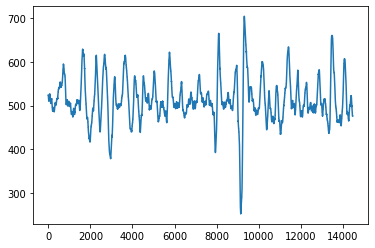

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(resp_data)

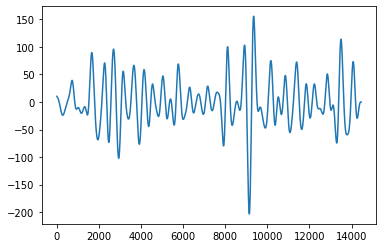

In [12]:
import biosppy.signals.resp as resp

processed_resp = resp.resp(signal=resp_data, sampling_rate=B.srate, show=False)
inter = processed_resp[2]
plt.plot(np.array(processed_resp[1]))

In [6]:
actuator_ip = '192.168.0.110'
actuator_port = 12000

osc_client = SimpleUDPClient(actuator_ip, actuator_port) 
osc_client.send_message("/actuator/inflate", 0.0)


In [ ]:
server.server_close()

In [ ]:
B.filtered

In [15]:
np.diff(processed_resp[2])

array([384, 357, 673, 270, 345, 231, 198, 250, 246, 211, 242, 270, 255,
       223, 198, 207, 255, 226, 207,  83, 221, 236, 304, 205, 209, 220,
       226, 221, 201, 287, 240, 223, 290,  55, 181, 256, 235, 260, 526,
       249, 189,  97, 174, 205, 287, 276, 251, 175, 191, 215, 385, 236,
       421, 246, 333, 225, 243])

In [17]:
new_resp = biofeatures.breathing(data = resp_data, buffer_length=2000, srate=100)

In [19]:
resp_int = new_resp.resp_intervals(resp_data)
resp_feat = new_resp.resp_features()

In [21]:
new_resp.features

{'breath_avg_len': 4.13,
 'inhale_duration': 71.7,
 'avg_inhale': 2.11,
 'exhale_duration': 72.87,
 'avg_exhale': 2.14,
 'inhale_exhale_ratio': 0.98}